In [ ]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import torch.nn.functional as F
from google.colab import drive

In [ ]:
# Read data (qj path)

drive.mount('/content/gdrive', force_remount=True)
train = pd.read_csv("/content/gdrive/MyDrive/Y2S2/SP3172/Hot_encoded_and_feature_scaled/correct_train.csv", encoding= 'ISO-8859-1', low_memory = False)
test = pd.read_csv("/content/gdrive/MyDrive/Y2S2/SP3172/Hot_encoded_and_feature_scaled/correct_test.csv", encoding= 'ISO-8859-1', low_memory = False)
val = pd.read_csv("/content/gdrive/MyDrive/Y2S2/SP3172/Hot_encoded_and_feature_scaled/correct_val.csv", encoding= 'ISO-8859-1', low_memory = False)

Mounted at /content/gdrive


In [ ]:
# Read data (Hx path)

drive.mount('/content/gdrive', force_remount=True)
train = pd.read_csv("/content/gdrive/MyDrive/SP3172/Hot_encoded_and_feature_scaled/correct_train.csv", encoding= 'ISO-8859-1', low_memory = False)
test = pd.read_csv("/content/gdrive/MyDrive/SP3172/Hot_encoded_and_feature_scaled/correct_test.csv", encoding= 'ISO-8859-1', low_memory = False)
val = pd.read_csv("/content/gdrive/MyDrive/SP3172/Hot_encoded_and_feature_scaled/correct_val.csv", encoding= 'ISO-8859-1', low_memory = False)

Mounted at /content/gdrive


In [ ]:
# Read a subset of data
# df_test = df.iloc[:, :]
# size = (df_test.iloc[:, 1:]).shape[1]
# size
test_ = test
train_ = train
val_ = val
size = (train_.shape[1])
size

1406283

In [ ]:
# Make the class so that the data could be loaded into DataLoader()

class MyDataset():

  def __init__(self,file_name):
    df=file_name

    x=df.iloc[:,2:].values
    y=df.iloc[:,:2].values
    #print(y)
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)
  
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

train_ = MyDataset(train_)
test_ = MyDataset(test_)
val_ = MyDataset(val_)

In [ ]:
# Model Building

# Input --> Hidden dim --> mean, std --> Parametrization trick --> Decoder --> Output
# input_dim: e.g. it will be 784 if your input is a tensor of 28x28
# h_dim: dim of hidden layers
# with batch normalisation + variational dropout

import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, input_dim, h_dim=1000, z_dim=10, dropout_rate=0.5):
        super().__init__()
        
        # Encoder
        # In the KL Divegence, hid22mu & hid22sigma will be pushed to learn the standard Gaussian
        self.input2hid1 = nn.Linear(input_dim, h_dim)
        self.hid12hid2 = nn.Linear(h_dim, h_dim)
        self.hid22mu = nn.Linear(h_dim, z_dim)
        self.hid22sigma = nn.Linear(h_dim, z_dim)
        
        # Decoder
        self.z2hid1 = nn.Linear(z_dim, h_dim)
        self.hid12hid2d = nn.Linear(h_dim, h_dim)
        self.hid22output = nn.Linear(h_dim, input_dim)
        
        self.bn1 = nn.BatchNorm1d(h_dim)
        self.bn2 = nn.BatchNorm1d(h_dim)
        self.bn3 = nn.BatchNorm1d(h_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.leakyrelu = nn.LeakyReLU()
        self.dropout_rate = dropout_rate
        
        
    def encode(self, x):
        # q_phi(z|x)
        
        hidden = self.leakyrelu(self.bn1(self.input2hid1(x)))
        hidden = self.relu(hidden)
        hidden = self.leakyrelu(self.bn2(self.hid12hid2(hidden)))
        mu, sigma = self.hid22mu(hidden), self.hid22sigma(hidden)
        return mu, sigma
        
        
    def decode(self, z):
        # p_theta(x|z)
        
        hidden = self.leakyrelu(self.bn3(self.z2hid1(z)))
        hidden = self.relu(hidden)
        hidden = F.dropout(self.leakyrelu(self.hid12hid2d(hidden)), p=self.dropout_rate, training=self.training)
        output = self.sigmoid(self.hid22output(hidden))
        return output
        
        
    def forward(self, x):
        mu, sigma = self.encode(x)
        eps = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*eps
        x_reconstruct = self.decode(z_reparametrized)
        return x_reconstruct, mu, sigma


In [ ]:
# Configuration

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
INPUT_DIM = size-2
H_DIM = 1000  
Z_DIM = 10
NUM_EPOCHS = 50
BATCH_SIZE = 61 #result.x[1]  #33
LR_RATE = 0.000849 #result.x[0]  #3e-4

# Dataset Loading

from torch.utils.data.dataset import random_split

train_loader = DataLoader(dataset = train_, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(dataset = val_, batch_size = BATCH_SIZE, shuffle = False)
model = VAE(INPUT_DIM, H_DIM, Z_DIM, dropout_rate=0.5).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LR_RATE)
dataloaders = {
    "train": train_loader,
    "validation": val_loader,
    "test": test_loader
}
loss_fn = nn.MSELoss(reduction = "sum") 



In [ ]:
# Load the saved model from a file

#qj path

loaded_model = VAE(INPUT_DIM)
loaded_model.load_state_dict(torch.load("/content/gdrive/MyDrive/Y2S2/SP3172/VAE/vae_model.pth"))
loaded_model.eval()  # Set the model to evaluation mode

KeyboardInterrupt: ignored

In [ ]:
# Load the saved model from a file

#hx path 

loaded_model = VAE(INPUT_DIM)
loaded_model.load_state_dict(torch.load("/content/gdrive/MyDrive/SP3172/VAE/vae_model.pth"))
loaded_model.eval()  # Set the model to evaluation mode

VAE(
  (input2hid1): Linear(in_features=1406281, out_features=1000, bias=True)
  (hid12hid2): Linear(in_features=1000, out_features=1000, bias=True)
  (hid22mu): Linear(in_features=1000, out_features=10, bias=True)
  (hid22sigma): Linear(in_features=1000, out_features=10, bias=True)
  (z2hid1): Linear(in_features=10, out_features=1000, bias=True)
  (hid12hid2d): Linear(in_features=1000, out_features=1000, bias=True)
  (hid22output): Linear(in_features=1000, out_features=1406281, bias=True)
  (bn1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)

In [ ]:
X_train = []
y_train = []
model = loaded_model
# Generate the latent vectors for each sample
with torch.no_grad():
    for x, label in dataloaders["train"]:
        x = x.to(DEVICE)
        _, mu, _ = model(x)
        X_train.append(mu.cpu().detach().numpy())
        y_train.append(label.numpy())

# y_ is the labels for z, can use the y_ and z to train the classifier model
# You might need to concatenate them idk? That depends on how you feed your model
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_train = y_train[:, 0]
print(y_train.shape)
print(X_train.shape)


(114,)
(114, 10)


In [ ]:
X_val = []
y_val = []
model = loaded_model
# Generate the latent vectors for each sample
with torch.no_grad():
    for x, label in dataloaders["validation"]:
        x = x.to(DEVICE)
        _, mu, _ = model(x)
        X_val.append(mu.cpu().detach().numpy())
        y_val.append(label.numpy())

# y_ is the labels for z, can use the y_ and z to train the classifier model
# You might need to concatenate them idk? That depends on how you feed your model
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_val = y_val[:, 0]
print(y_val.shape)
print(X_val.shape)


(6,)
(6, 10)


In [ ]:

X_test = []
y_test = []
model = loaded_model
# Generate the latent vectors for each sample
with torch.no_grad():
    for x, label in dataloaders["test"]:
        x = x.to(DEVICE)
        _, mu, _ = model(x)
        X_test.append(mu.cpu().detach().numpy())
        y_test.append(label.numpy())

# y_ is the labels for z, can use the y_ and z to train the classifier model
# You might need to concatenate them idk? That depends on how you feed your model
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
y_test = y_test[:,0]
print(y_test.shape)
print(X_test.shape)


(7,)
(7, 10)


# LightGBM 

In [ ]:
import lightgbm as lgb
params = {
    'application': 'binary', # for binary classification
#     'num_class' : 1, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 32,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'binary_error',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5,# minimum number of data needed in a leaf]
    'class_weight': 'balanced'
    ''
}

# Initiate classifier to use
lightgbm_model = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'],class_weight = params['class_weight'])

# To view the default model parameters:
#mdl.get_params().keys()
lightgbm_model.get_params().keys()


dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin'])

In [ ]:
# print the scores on training and validation set
lightgbm_model.fit(X_train, y_train)
print('Training set score: {:.4f}'.format(lightgbm_model.score(X_train,y_train )))

print('Validation set score: {:.4f}'.format(lightgbm_model.score(X_val, y_val)))

Training set score: 1.0000
Validation set score: 1.0000


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
y_val_pred = lightgbm_model.predict(X_val)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5 0]
 [0 1]]

True Positives(TP) =  5

True Negatives(TN) =  1

False Positives(FP) =  0

False Negatives(FN) =  0


<Axes: >

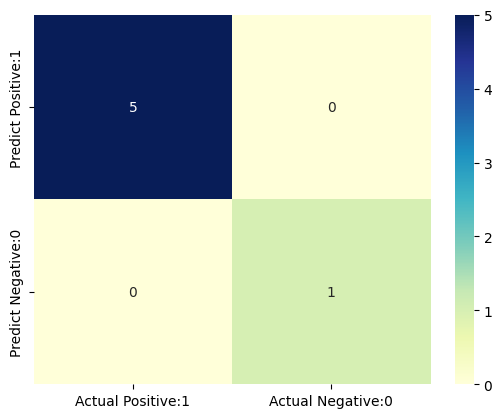

In [ ]:
# visualize confusion matrix with seaborn heatmap
import seaborn as sns

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred)) 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



### LightGBM (tuning) 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


In [ ]:


gridParams = {
    'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'num_leaves': [6, 8, 12, 16, 32, 64, 128, 256, 512],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_bin': [255, 510, 1020],
    'random_state': [500],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1, 2, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 2, 5, 10],
    'class_weight': ["balanced", None],
    'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
    'bagging_freq': [1, 3, 5, 7, 9, 11],
    'max_depth': [-1, 5, 10, 15, 20, 25],
    'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
    'l2_leaf_reg' : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
}


model = lgb.LGBMClassifier()
grid = RandomizedSearchCV(model, gridParams, verbose=1, cv=4, n_jobs=-1, scoring='roc_auc')
# Run the grid
grid.fit(X_train, y_train)
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.7 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.66 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
{'subsample': 0.7, 'reg_lambda': 1.4, 'reg_alpha': 1.2, 'random_state': 500, 'objective': 'binary', 'num_leaves': 12, 'n_estimators': 8, 'max_depth': 5, 'max_bin': 255, 'learning_rate': 0.003, 'l2_leaf_reg': 1, 'feature_fraction': 0.8, 'colsample_bytree': 0.66, 'class_weight': None, 'boosting_type': 'dart', 'bagging_freq': 10, 'bagging_fraction': 0.9}
0.5289695423623995


In [ ]:
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate'] 
params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
params['class_weight'] = grid.best_params_['class_weight']
params['bagging_fraction'] = grid.best_params_['bagging_fraction']
params['bagging_freq'] = grid.best_params_['bagging_freq']
params['max_depth'] = grid.best_params_['max_depth']
params['feature_fraction'] = grid.best_params_['feature_fraction']
params['n_estimators'] = grid.best_params_['n_estimators']
params['l2_leaf_reg'] = grid.best_params_['l2_leaf_reg']
params['boosting_type'] = grid.best_params_['boosting_type']



lightgbm_tuned = lgb.LGBMClassifier(
          boosting_type=params['boosting_type'], 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          #max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'],
          class_weight = params['class_weight'],
          learning_rate = params['learning_rate'],
          n_estimators = params['n_estimators'],
          num_leaves = params['num_leaves'],
          boosting =params['boosting'] ,
          colsample_bytree = params['colsample_bytree'],
          reg_alpha = params['reg_alpha'],
          reg_lambda = params['reg_lambda'],
          bagging_fraction = params['bagging_fraction'],
          bagging_freq = params['bagging_freq'], 
          max_depth = params['max_depth'],
          feature_fraction = params['feature_fraction'],
          l2_leaf_reg =  params['l2_leaf_reg'],
          random_state = 500

          )

lightgbm_tuned.fit(X_train, y_train)

#p_test = lightgbm_tuned.predict(X_test)


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(bagging_fraction=0.9, bagging_freq=10, boosting='gbdt',
               boosting_type='dart', colsample_bytree=0.66,
               feature_fraction=0.8, l2_leaf_reg=1, learning_rate=0.003,
               max_bin=255, max_depth=5, min_child_samples=5,
               min_child_weight=1, min_split_gain=0.5, n_estimators=8, n_jobs=5,
               num_leaves=12, objective='binary', random_state=500,
               reg_alpha=1.2, reg_lambda=1.4, silent=True, subsample=0.7,
               subsample_for_bin=200)

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(lightgbm_tuned.score(X_train,y_train )))

print('Test set score: {:.4f}'.format(lightgbm_tuned.score(X_test, y_test)))


Training set score: 0.7632
Test set score: 0.5714


In [ ]:
y_test_pred = lightgbm_tuned.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[4 0]
 [3 0]]

True Positives(TP) =  4

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  3


<Axes: >

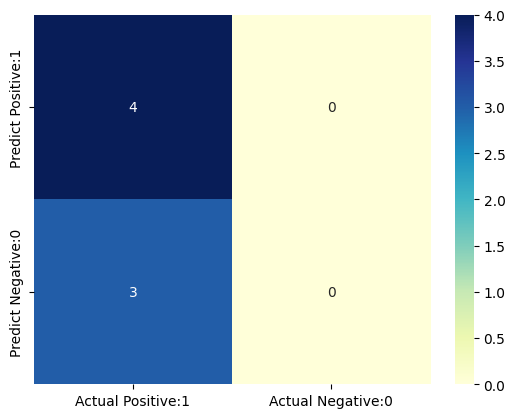

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         4
         1.0       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
metrics.auc(fpr, tpr) 


0.5

# CatBoost 

In [ ]:
# Catboost
!pip install catboost
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 23.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
#initialising my model 
params = {
    'iterations':50, 
    'learning_rate':0.001, 
    'loss_function': 'CrossEntropy',
    'random_seed' : 500

    
}

catboost_model = CatBoostClassifier(
    iterations=50, 
    learning_rate=0.001, 
    loss_function='CrossEntropy',
    random_seed = 500
)

catboost_model.fit(X_train, y_train,
        eval_set=(X_val, y_val), 
        verbose=False
)

In [ ]:
# metrics 

In [ ]:
# print the scores on training and validation set

print('Training set score: {:.4f}'.format(catboost_model.score(X_train,y_train )))

print('Validation set score: {:.4f}'.format(catboost_model.score(X_val, y_val)))

Training set score: 0.7632
Validation set score: 0.8333


In [ ]:
y_val_pred = catboost_model.predict(X_val)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5 0]
 [1 0]]

True Positives(TP) =  5

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  1


<Axes: >

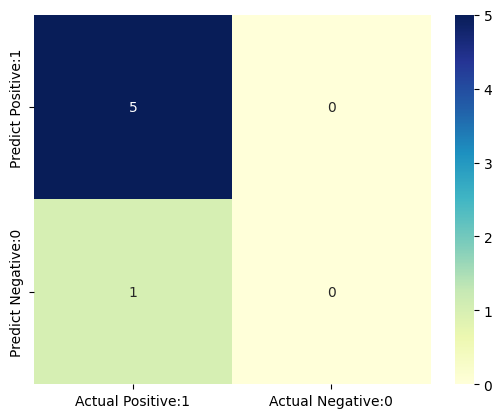

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred)) 

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Catboost Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gridParams = {
    'depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.001, 0.01, 0.1],
    'iterations': [10, 20, 30, 40, 50],
    'l2_leaf_reg': [1, 5, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bylevel': [0.5, 0.7, 0.9],
    'bagging_temperature': [0.0, 0.2, 0.4],
    'random_strength': [0.0, 0.2, 0.4],
    'border_count': [32, 64, 128],
    'loss_function': ['Logloss', 'CrossEntropy'],
    #'random_seed': [500],
    'early_stopping_rounds': [5, 10, 15, 20, 25]
}



In [ ]:
model = CatBoostClassifier()
grid = RandomizedSearchCV(model, gridParams, cv = 2, n_jobs=-1,scoring = 'f1')
grid.fit(X_train, y_train)


# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

0:	learn: 0.6772197	total: 1.26ms	remaining: 36.6ms
1:	learn: 0.6646922	total: 2.26ms	remaining: 31.7ms
2:	learn: 0.6533449	total: 2.99ms	remaining: 26.9ms
3:	learn: 0.6401950	total: 3.69ms	remaining: 24ms
4:	learn: 0.6308771	total: 4.41ms	remaining: 22ms
5:	learn: 0.6142379	total: 5.06ms	remaining: 20.3ms
6:	learn: 0.6028228	total: 5.63ms	remaining: 18.5ms
7:	learn: 0.5900067	total: 6.27ms	remaining: 17.2ms
8:	learn: 0.5822876	total: 6.9ms	remaining: 16.1ms
9:	learn: 0.5736749	total: 7.47ms	remaining: 14.9ms
10:	learn: 0.5664092	total: 8.1ms	remaining: 14ms
11:	learn: 0.5576099	total: 8.74ms	remaining: 13.1ms
12:	learn: 0.5465284	total: 9.3ms	remaining: 12.2ms
13:	learn: 0.5365391	total: 9.9ms	remaining: 11.3ms
14:	learn: 0.5269548	total: 10.6ms	remaining: 10.6ms
15:	learn: 0.5199189	total: 11.2ms	remaining: 9.78ms
16:	learn: 0.5137084	total: 11.8ms	remaining: 9.02ms
17:	learn: 0.5056253	total: 12.4ms	remaining: 8.29ms
18:	learn: 0.4991496	total: 13.1ms	remaining: 7.58ms
19:	learn: 0.

In [ ]:
# then fit those parameters to get tuned model 

In [ ]:
params['depth'] = grid.best_params_['depth']
params['learning_rate'] = grid.best_params_['learning_rate'] 
params['iterations'] = grid.best_params_['iterations']
params['loss_function'] = grid.best_params_['loss_function']

params['early_stopping_rounds'] = grid.best_params_['early_stopping_rounds']
params['l2_leaf_reg'] = grid.best_params_['l2_leaf_reg']
params['subsample'] = grid.best_params_['subsample']
params['colsample_bylevel'] = grid.best_params_['colsample_bylevel']
params['bagging_temperature'] = grid.best_params_['bagging_temperature']
params['random_strength'] = grid.best_params_['random_strength']
params['border_count'] = grid.best_params_['border_count']



catboost_tuned = CatBoostClassifier(
         
  
          depth = params['depth'],
          learning_rate = params['learning_rate'], 
          iterations = params['iterations'],
          loss_function = params['loss_function'], 
        
          early_stopping_rounds = params['early_stopping_rounds'], 
          l2_leaf_reg = params['l2_leaf_reg'],
          subsample = params['subsample'],
          colsample_bylevel = params['colsample_bylevel'],
          bagging_temperature = params['bagging_temperature'],
          random_strength = params['random_strength'],
          border_count =params['border_count'] ,
         
          #random_state = 500

          )

catboost_tuned.fit(X_train, y_train)

0:	learn: 0.6772197	total: 561us	remaining: 16.3ms
1:	learn: 0.6646922	total: 1.38ms	remaining: 19.3ms
2:	learn: 0.6533449	total: 2.03ms	remaining: 18.3ms
3:	learn: 0.6401950	total: 2.64ms	remaining: 17.2ms
4:	learn: 0.6308771	total: 3.26ms	remaining: 16.3ms
5:	learn: 0.6142379	total: 3.84ms	remaining: 15.4ms
6:	learn: 0.6028228	total: 4.42ms	remaining: 14.5ms
7:	learn: 0.5900067	total: 4.98ms	remaining: 13.7ms
8:	learn: 0.5822876	total: 5.56ms	remaining: 13ms
9:	learn: 0.5736749	total: 6.15ms	remaining: 12.3ms
10:	learn: 0.5664092	total: 6.79ms	remaining: 11.7ms
11:	learn: 0.5576099	total: 7.46ms	remaining: 11.2ms
12:	learn: 0.5465284	total: 8.15ms	remaining: 10.7ms
13:	learn: 0.5365391	total: 8.81ms	remaining: 10.1ms
14:	learn: 0.5269548	total: 9.5ms	remaining: 9.5ms
15:	learn: 0.5199189	total: 10.2ms	remaining: 8.96ms
16:	learn: 0.5137084	total: 10.9ms	remaining: 8.35ms
17:	learn: 0.5056253	total: 11.7ms	remaining: 7.8ms
18:	learn: 0.4991496	total: 12.4ms	remaining: 7.18ms
19:	learn

In [ ]:
# metrics 

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(catboost_tuned.score(X_train,y_train )))

print('Test set score: {:.4f}'.format(catboost_tuned.score(X_test, y_test)))

Training set score: 0.9649
Test set score: 0.5714


In [ ]:
y_test_pred = catboost_tuned.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[4 0]
 [3 0]]

True Positives(TP) =  4

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  3


<Axes: >

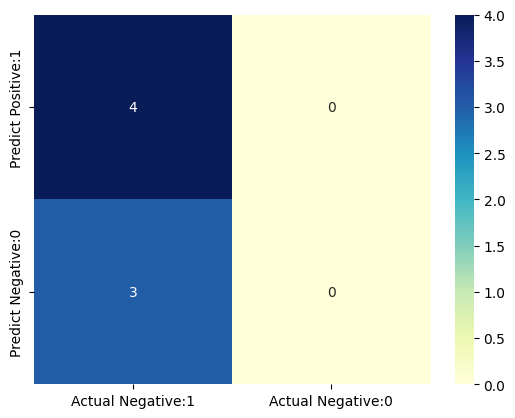

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu') 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         4
         1.0       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred, pos_label=2)
metrics.auc(fpr, tpr)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


nan

# XGBoost

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn import metrics


In [ ]:
import xgboost as xgb

#Train the XGboost Model for Classification
# params = {
#     random_seed: 500
# }
xgboost_model = xgb.XGBClassifier(
    random_seed= 500,
    learning_rate = 0.001 ,
    gamma = 0,
    subsample = 0.8
)
xgboost_model = xgboost_model.fit(X_train, y_train)

[11:06:47] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



In [ ]:
# metrics

In [ ]:
# print the scores on training and validation set

print('Training set score: {:.4f}'.format(xgboost_model.score(X_train,y_train )))

print('Validation set score: {:.4f}'.format(xgboost_model.score(X_val, y_val)))

Training set score: 0.8947
Validation set score: 0.8333


In [ ]:
y_val_pred = xgboost_model.predict(X_val)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5 0]
 [1 0]]

True Positives(TP) =  5

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  1


<Axes: >

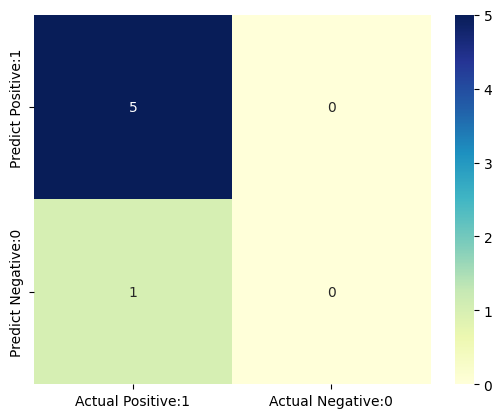

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred)) 

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost tuning

In [ ]:
# Define hyperparameter grid
gridParams = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7, 9],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1],
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1, 5, 10, 20, 50, 100],
    'early_stopping_rounds': [5, 10, 15, 20],
    'n_estimators': [50, 100, 200, 300, 500, 1000]
}

model = xgb.XGBClassifier(objective='binary:logistic')
grid = RandomizedSearchCV(model, gridParams, cv=2, n_jobs=-1, scoring='roc_auc', error_score='raise', n_iter=50)
grid.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)




[0]	validation_0-logloss:0.71256
[1]	validation_0-logloss:0.61768
[2]	validation_0-logloss:0.66506
[3]	validation_0-logloss:0.59313
[4]	validation_0-logloss:0.53418
[5]	validation_0-logloss:0.48028
[6]	validation_0-logloss:0.44205
[7]	validation_0-logloss:0.38808
[8]	validation_0-logloss:0.39055
[9]	validation_0-logloss:0.35560
[10]	validation_0-logloss:0.39288
[11]	validation_0-logloss:0.45709
[12]	validation_0-logloss:0.45293
[13]	validation_0-logloss:0.45661
[14]	validation_0-logloss:0.51003
[15]	validation_0-logloss:0.52483
[16]	validation_0-logloss:0.47298
[17]	validation_0-logloss:0.44877
[18]	validation_0-logloss:0.41035
[19]	validation_0-logloss:0.35672
[20]	validation_0-logloss:0.33277
[21]	validation_0-logloss:0.28624
[22]	validation_0-logloss:0.28983
[23]	validation_0-logloss:0.25570
[24]	validation_0-logloss:0.26754
[25]	validation_0-logloss:0.25374
[26]	validation_0-logloss:0.24718
[27]	validation_0-logloss:0.25579
[28]	validation_0-logloss:0.26931
[29]	validation_0-loglos

In [ ]:
params['learning_rate'] = grid.best_params_['learning_rate']
params['max_depth'] = grid.best_params_['max_depth'] 
params['min_child_weight'] = grid.best_params_['min_child_weight']
params['subsample'] = grid.best_params_['subsample']
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['gamma'] = grid.best_params_['gamma']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['objective'] = grid.best_params_['objective']
params['scale_pos_weight'] = grid.best_params_['scale_pos_weight']
params['early_stopping_rounds'] = grid.best_params_['early_stopping_rounds']
params['n_estimators'] = grid.best_params_['n_estimators']

xgboost_tuned = xgb.XGBClassifier(
    learning_rate=params['learning_rate'], 
    max_depth=params['max_depth'],    min_child_weight=params['min_child_weight'], 
    subsample=params['subsample'],
    colsample_bytree=params['colsample_bytree'], 
    gamma=params['gamma'], 
    reg_alpha=params['reg_alpha'], 
    reg_lambda=params['reg_lambda'],
    objective=params['objective'],
    scale_pos_weight=params['scale_pos_weight'],
    early_stopping_rounds=params['early_stopping_rounds'],
    n_estimators=params['n_estimators'], 
    # random_state=500
)

xgboost_tuned.fit(X_train, y_train, eval_set = [(X_val, y_val)])

[0]	validation_0-logloss:0.71256
[1]	validation_0-logloss:0.61768
[2]	validation_0-logloss:0.66506
[3]	validation_0-logloss:0.59313
[4]	validation_0-logloss:0.53418
[5]	validation_0-logloss:0.48028
[6]	validation_0-logloss:0.44205
[7]	validation_0-logloss:0.38808
[8]	validation_0-logloss:0.39055
[9]	validation_0-logloss:0.35560
[10]	validation_0-logloss:0.39288
[11]	validation_0-logloss:0.45709
[12]	validation_0-logloss:0.45293
[13]	validation_0-logloss:0.45661
[14]	validation_0-logloss:0.51003
[15]	validation_0-logloss:0.52483
[16]	validation_0-logloss:0.47298
[17]	validation_0-logloss:0.44877
[18]	validation_0-logloss:0.41035
[19]	validation_0-logloss:0.35672
[20]	validation_0-logloss:0.33277
[21]	validation_0-logloss:0.28624
[22]	validation_0-logloss:0.28983
[23]	validation_0-logloss:0.25570
[24]	validation_0-logloss:0.26754
[25]	validation_0-logloss:0.25374
[26]	validation_0-logloss:0.24718
[27]	validation_0-logloss:0.25579
[28]	validation_0-logloss:0.26931
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=15,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# metrics 

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(xgboost_tuned.score(X_train,y_train )))

print('Test set score: {:.4f}'.format(xgboost_tuned.score(X_test, y_test)))


Training set score: 1.0000
Test set score: 0.5714


In [ ]:
y_test_pred = xgboost_tuned.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[3 1]
 [2 1]]

True Positives(TP) =  3

True Negatives(TN) =  1

False Positives(FP) =  1

False Negatives(FN) =  2


<Axes: >

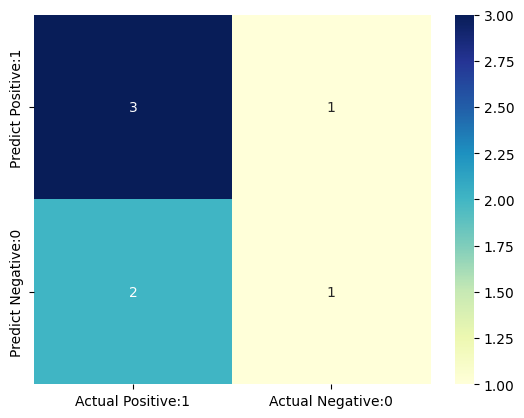

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.50      0.33      0.40         3

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7



In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
metrics.auc(fpr, tpr) 


# ANN

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn import metrics


In [ ]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# sequential model to initialise our ann and dense module to build the layers
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_shape = (114,10))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_val)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_val, y_val,
                            batch_size=10)
print('Validation score:', score)
print('Validation accuracy:', acc)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)

SyntaxError: ignored

In [ ]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

In [ ]:
from sklearn.metrics import roc_curve
predict_prob=classifier.predict(X_val)
predict_classes=np.argmax(predict_prob,axis=1)
fpr, tpr, thresholds = roc_curve(y_val, predict_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,predict_prob)

In [ ]:
# Part 4 - Evaluating, Improving and Tuning the ANN

# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 18))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100,verbose=0)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
mean = accuracies.mean()
variance = accuracies.std()

In [ ]:
print('Mean accuracy score of 10 different models using Kfold cross validation: {}'.format(mean))
print('Standard Deviation of accuracy score of 10 different models using Kfold cross validation: {}'.format(variance))

In [ ]:
# Improving the ANN
from keras.layers import Dropout
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 18))
classifier.add(Dropout(rate = 0.1))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = 0.1))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

# Part 3 - Making predictions and evaluating the model

score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_val)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_val, y_val,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)

In [ ]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

In [ ]:
from sklearn.metrics import roc_curve


predict_prob=classifier.predict(X_val)
predict_classes=np.argmax(predict_prob,axis=1)

fpr, tpr, thresholds = roc_curve(y_val, predict_prob)



plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,predict_prob)

In [ ]:
# Tuning the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 18))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 200,300,400,500],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train,verbose = 0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [ ]:
print('Best Parameters after tuning: {}'.format(best_parameters))
print('Best f1-score after tuning: {}'.format(best_accuracy))

In [ ]:

y_pred = grid_search.predict(X_val)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

In [ ]:

y_pred = grid_search.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

# Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
params = {
    'penalty': 'l2',
    'max_iter': 100
}

logisticregression_model = LogisticRegression(random_state=42, **params)

logisticregression_model.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [ ]:
# metrics 

In [ ]:
# print the scores on training and validation set

print('Training set score: {:.4f}'.format(logisticregression_model.score(X_train,y_train )))

print('Validation set score: {:.4f}'.format(logisticregression_model.score(X_val, y_val)))

Training set score: 0.7895
Validation set score: 0.8333


In [ ]:
y_val_pred = logisticregression_model.predict(X_val)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5 0]
 [1 0]]

True Positives(TP) =  5

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  1


<Axes: >

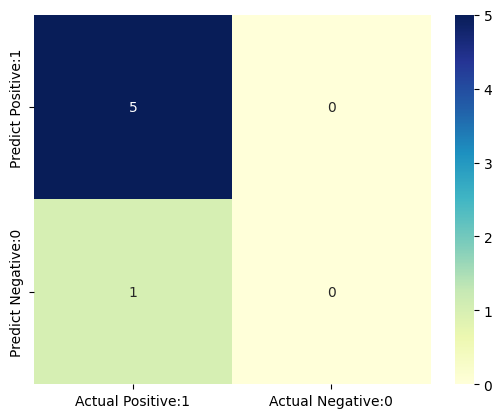

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred)) 

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic regression tuning

In [ ]:
gridParams = {
    'penalty': ['l2'],
    'C': [0.1, 0.5, 1.0, 5.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100,250, 500, 1000]}

In [ ]:
model = LogisticRegression()
grid = RandomizedSearchCV(model, gridParams, cv = 2, n_jobs=-1,scoring = 'f1')
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'solver': 'sag', 'penalty': 'l2', 'max_iter': 500, 'C': 0.5}
0.18803418803418803


In [ ]:
params['solver'] = grid.best_params_['solver']
params['penalty'] = grid.best_params_['penalty'] 
params['max_iter'] = grid.best_params_['max_iter']
params['C'] = grid.best_params_['C']



logisticregression_tuned = LogisticRegression(

          solver = params['solver'],
          penalty = params['penalty'],
          max_iter = params['max_iter'],
          C = params['C'],

          )

logisticregression_tuned.fit(X_train, y_train)

LogisticRegression(C=0.5, max_iter=500, solver='sag')

In [ ]:
# metrics 

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logisticregression_tuned.score(X_train,y_train )))

print('Test set score: {:.4f}'.format(logisticregression_tuned.score(X_test, y_test)))


Training set score: 0.7895
Test set score: 0.5714


In [ ]:
y_test_pred = logisticregression_tuned.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[4 0]
 [3 0]]

True Positives(TP) =  4

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  3


<Axes: >

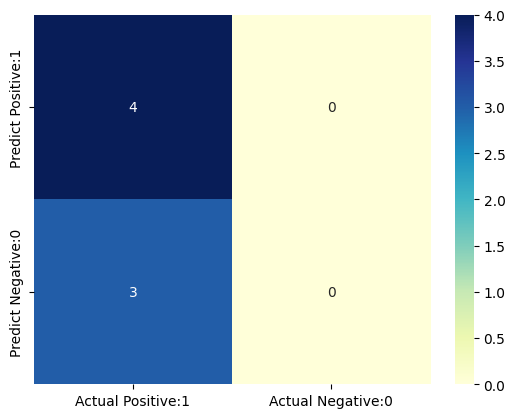

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         4
         1.0       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred, pos_label=2)
metrics.auc(fpr, tpr)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


nan

# Random Forest

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
# create model
params = {
    "n_estimators" : 50, 
    "max_features" : 'sqrt',
    "max_depth" : 10,     
}
randomforest_model = RandomForestClassifier(random_state=500, 
                                            n_estimators = 50,
                                             max_features = 'sqrt',
                                            max_depth = 10,)

randomforest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=500)

In [ ]:
# metrics 

In [ ]:
# print the scores on training and validation set

print('Training set score: {:.4f}'.format(randomforest_model.score(X_train,y_train )))

print('Validation set score: {:.4f}'.format(randomforest_model.score(X_val, y_val)))

Training set score: 1.0000
Validation set score: 0.8333


In [ ]:
y_val_pred = randomforest_model.predict(X_val)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5 0]
 [1 0]]

True Positives(TP) =  5

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  1


<Axes: >

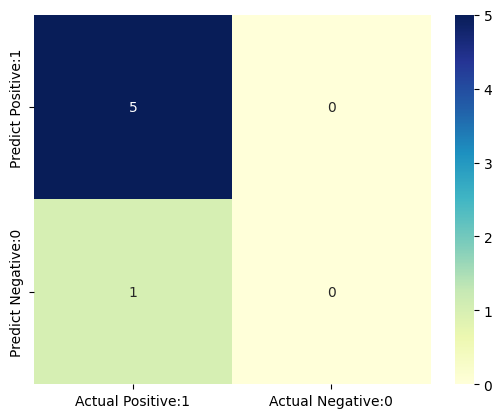

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred)) 

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random forest tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint as sp_randint


# specify the parameters and distributions to sample from
param_dist = {
    "n_estimators": sp_randint(50, 500),
    "max_features": ['sqrt', 'log2', None],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": sp_randint(2, 10),
    "min_samples_leaf": sp_randint(1, 4),
    "bootstrap": [True, False]
}

In [ ]:
model = RandomForestClassifier()
grid = RandomizedSearchCV(model, gridParams, cv = 2, n_jobs=-1,scoring = 'f1')
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'bootstrap': False}
0.3484848484848485


In [ ]:
params['n_estimators'] = grid.best_params_['n_estimators']
params['max_features'] = grid.best_params_['max_features'] 
params['max_depth'] = grid.best_params_['max_depth']
params['min_samples_split'] = grid.best_params_['min_samples_split']
params['min_samples_leaf'] = grid.best_params_['min_samples_leaf']
params['bootstrap'] = grid.best_params_['bootstrap']
#params['class_weights'] = grid.best_params_['class_weights']


randomforest_tuned = RandomForestClassifier(
          n_estimators=params['n_estimators'], 
          max_features = params['max_features'],
          max_depth = params['max_depth'], 
          min_samples_split = params['min_samples_split'],
          min_samples_leaf = params['min_samples_leaf'], 
          bootstrap = params['bootstrap'], 
          #class_weights = params['class_weights'], 
          #random_state = 500
          )

randomforest_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features=None, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=500)

In [ ]:
# metrics 

In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(randomforest_tuned.score(X_train,y_train )))

print('Test set score: {:.4f}'.format(randomforest_tuned.score(X_test, y_test)))


Training set score: 0.9211
Test set score: 0.5714


In [ ]:
y_test_pred = randomforest_tuned.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[4 0]
 [3 0]]

True Positives(TP) =  4

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  3


<Axes: >

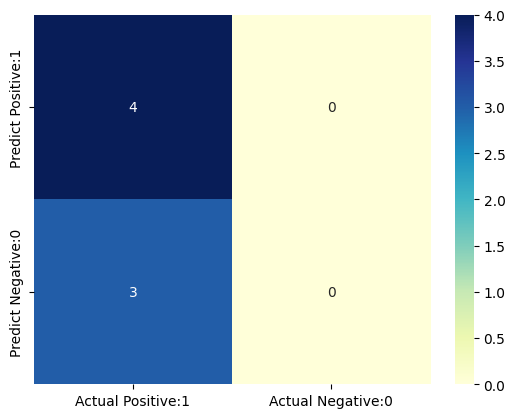

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         4
         1.0       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred, pos_label=2)
metrics.auc(fpr, tpr)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


nan

In [ ]:
import joblib

# Save the trained model
joblib.dump(randomforest_tuned, '/content/gdrive/MyDrive/Y2S2/SP3172/VAE/randomforest_tuned.pkl')

['/content/gdrive/MyDrive/Y2S2/SP3172/VAE/randomforest_tuned.pkl']